# Reverse Engineering Trading Strategies

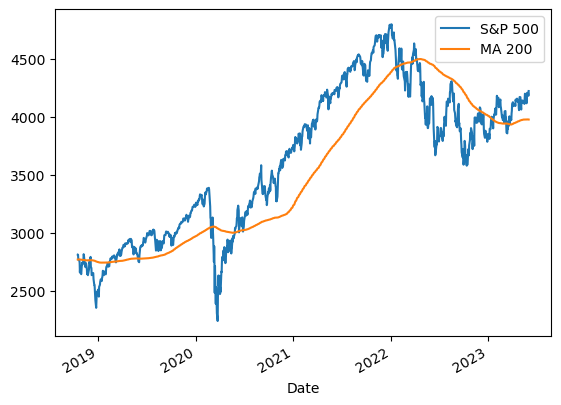

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf

sp500 = yf.download('^GSPC','2018-01-01',datetime.today(), progress=False)['Close'].rename('S&P 500')
ma_200 = sp500.rolling(window=200).mean().rename('MA 200')
data = pd.concat([sp500, ma_200], axis=1).dropna()
data.plot();

#### Adding noice data

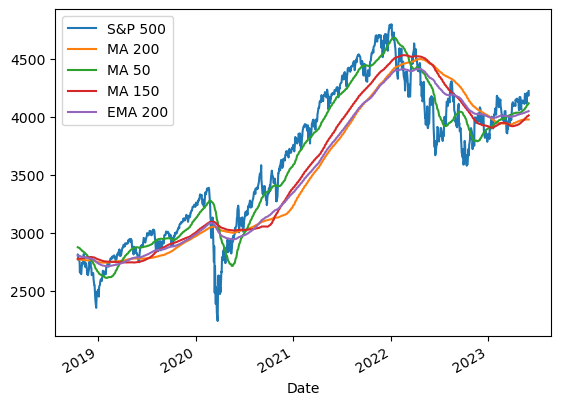

In [2]:
ma_50 = sp500.rolling(window=50).mean().rename('MA 50')
ma_150 = sp500.rolling(window=150).mean().rename('MA 150')
ema_200 = sp500.ewm(span=200).mean().rename('EMA 200')
data = pd.concat([sp500, ma_200, ma_50, ma_150, ema_200], axis=1).dropna()
data.plot();

#### Feature engineering - Differences

In [3]:
data['ma200_diff'] = data['S&P 500'] - data['MA 200'] 
data['ma50_diff'] = data['S&P 500'] - data['MA 50'] 
data['ma150_diff'] = data['S&P 500'] - data['MA 150'] 
data['ema200_diff'] = data['S&P 500'] - data['EMA 200'] 
data

,S&P 500,MA 200,MA 50,MA 150,EMA 200,ma200_diff,ma50_diff,ma150_diff,ema200_diff
Date,,,,,,,,,
2018-10-16,2809.919922,2767.173700,2873.888394,2773.885200,2801.187952,42.746222,-63.968472,36.034722,8.731969
2018-10-17,2809.209961,2767.740699,2872.903594,2774.297733,2801.280123,41.469261,-63.693633,34.912228,7.929838
2018-10-18,2768.780029,2768.019299,2871.125195,2774.409533,2800.907280,0.760730,-102.345166,-5.629504,-32.127251
2018-10-19,2767.780029,2768.238250,2869.409194,2774.775267,2800.527820,-0.458220,-101.629165,-6.995238,-32.747791
2018-10-22,2755.879883,2768.301899,2867.861191,2775.034867,2800.017163,-12.422017,-111.981309,-19.154984,-44.137280
...,...,...,...,...,...,...,...,...,...
2023-05-25,4151.279785,3975.972263,4095.153604,3999.000477,4041.386410,175.307522,56.126182,152.279308,109.893375
2023-05-26,4205.450195,3975.948313,4100.057007,4002.598278,4043.018888,229.501882,105.393188,202.851917,162.431307
2023-05-30,4205.520020,3975.939563,4105.834609,4005.616745,4044.635817,229.580457,99.685410,199.903275,160.884203


#### Adding class to predict

In [4]:
data['long'] = data['ma200_diff'] > 0
data

,S&P 500,MA 200,MA 50,MA 150,EMA 200,ma200_diff,ma50_diff,ma150_diff,ema200_diff,long
Date,,,,,,,,,,
2018-10-16,2809.919922,2767.173700,2873.888394,2773.885200,2801.187952,42.746222,-63.968472,36.034722,8.731969,True
2018-10-17,2809.209961,2767.740699,2872.903594,2774.297733,2801.280123,41.469261,-63.693633,34.912228,7.929838,True
2018-10-18,2768.780029,2768.019299,2871.125195,2774.409533,2800.907280,0.760730,-102.345166,-5.629504,-32.127251,True
2018-10-19,2767.780029,2768.238250,2869.409194,2774.775267,2800.527820,-0.458220,-101.629165,-6.995238,-32.747791,False
2018-10-22,2755.879883,2768.301899,2867.861191,2775.034867,2800.017163,-12.422017,-111.981309,-19.154984,-44.137280,False
...,...,...,...,...,...,...,...,...,...,...
2023-05-25,4151.279785,3975.972263,4095.153604,3999.000477,4041.386410,175.307522,56.126182,152.279308,109.893375,True
2023-05-26,4205.450195,3975.948313,4100.057007,4002.598278,4043.018888,229.501882,105.393188,202.851917,162.431307,True
2023-05-30,4205.520020,3975.939563,4105.834609,4005.616745,4044.635817,229.580457,99.685410,199.903275,160.884203,True


#### Reverse engineering

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = DecisionTreeClassifier(max_depth=5)
y = data.pop('long')
X = data.values
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=5)

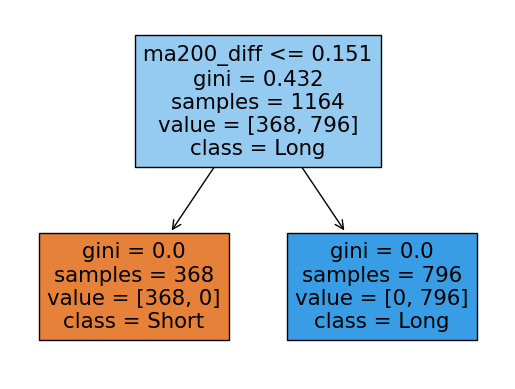

In [6]:
plot_tree(tree_clf, 
          feature_names=data.columns,  
          class_names=['Short', 'Long'],
          filled=True);